# Neural Network Testing Framework
This notebook is intended to be a general framework for testing Neural Neworks on the EEG data set. While the initial iteration of this notebook is used for a simple Convolutional Neural Network (CNN), other networks using PyTorch can be implemented and assigned to the neural network variable. Many of the beginning cells are used to intialize for a Google Drive Colaboratory notebook GPU usability and can be ignored as necessary.

---



## Initialization
Google Drive access, PyTorch, etc.

In [0]:
!kill -9 -1

This section provides access to the user's Google drive.

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


This section creates a drive that links to the user's Google drive.

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

This section installs PyTorch.

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

This section installs keras

In [4]:
!pip install keras

## Imports

Imports can be added as necessary.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.cuda
from torch.utils.data import Dataset
from torch.autograd import Variable
import torch.autograd





In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import h5py
from sklearn.model_selection import train_test_split




## Flags and Settings

In [0]:
use_cuda = True



## Classes

### EEGDataset
This class inherits the torch.utils.data.Dataset class to be used with the torch.utils.data.Dataloader class.

In [6]:
class EEGDataset(Dataset):
  """EEG dataset."""
  
  def __init__(self, x, y, transform=None):
    """
    Args:
      x (numpy array): Input data of shape 
                       num_trials x num_electrodes x num_time_bins.
      y (numpy array): Output data of shape num_trials x 1.
      transform (callable, optional): Optional transform to be applied.
    """
    self.x = x
    self.y = y
    self.transform = transform
    
  def __len__(self):
    return len(self.x)
  
  def __getitem__(self, idx):
    x_sample = torch.from_numpy(self.x[idx])
    y_sample = torch.IntTensor([int(self.y[idx])])
    
    if self.transform:
      pass #FIXME
    
    return x_sample, y_sample

NameError: ignored

### EEGMinimalContainer
This class holds a train and test EEGDataset. It processes the data into a (N, C, H, W) format in time.

In [0]:
class EEGMinimalContainer():
  """EEG container for training and testing datasets."""
  
  def __init__(self, data_dir, train_subject=None, test_subject=None, 
               remove_eog_channels=True, seed=42):
    """
    Args:
      data_dir (string): Path to all A0iT_slice.mat files for i in [1, 9].
      train_subject(int): Subject to train on. If None, train on all.
      test_subject(int): Subject to test on. If None, train on all except for
                         train_subject. Only used if train_subject is not None.
    """
    self.X_train = None
    self.y_train = None
    self.X_test = None
    self.y_test = None
    self.train_dataset = None
    self.test_dataset = None
    np.random.seed(seed)
    
    if train_subject is None:
      # Step 1: Append all of the input and output data together
      X = None
      y = None
      end = np.empty(9)
      for i in np.arange(9):
        A0iT = h5py.File(data_dir + ('/A0%dT_slice.mat' % (i+1)), 'r')
        X_temp = np.copy(A0iT['image'])
        y_temp = np.copy(A0iT['type'])
#        print(X_temp.shape)
 #       print(y_temp.shape)
        y_temp = y_temp[0,0:X_temp.shape[0]:1]
        y_temp = np.asarray(y_temp, dtype=np.int32)
        X = X_temp if X is None else np.append(X, X_temp, axis=0)
        y = y_temp if y is None else np.append(y, y_temp, axis=0)
        end[i] = X_temp.shape[0] if i == 0 else X_temp.shape[0] + end[i-1]
      X = np.expand_dims(X, axis=1)
      y -= 769
      # Step 2: Remove the EOG
      if remove_eog_channels:
        X = X[:, :, 0:22, :] 
      # Step 3: Remove NaN trials
      remove_list = []
      for i in range(len(X)):
        if np.isnan(X[i]).any():
          remove_list.append(i)
      for trial_row in remove_list:
        end[end > trial_row] -= 1
      X = np.delete(X, remove_list, axis=0)
      y = np.delete(y, remove_list, axis=0)
      # Step 4: Generate an train/test split
      remove_list = []
      self.X_test = {}
      self.y_test = {}
      self.test_dataset = {}
      sloc = 0
      for i, eloc in enumerate(end, 1):
        t_list = np.random.choice(np.arange(sloc, eloc), 50, replace=False)
        t_list = t_list.astype(int)
        self.X_test[str(i)] = X[t_list, :, :, :]
        self.y_test[str(i)] = y[t_list]
        self.test_dataset[str(i)] = EEGDataset(X[t_list, :, :, :], y[t_list])
        remove_list = remove_list + t_list.tolist()
        sloc = eloc
      self.X_train = np.delete(X, remove_list, axis=0)
      self.y_train = np.delete(y, remove_list, axis=0)
      self.train_dataset = EEGDataset(self.X_train, self.y_train)
      
      print('EEGContainer X_train: ' + str(self.X_train.shape))
      print('EEGContainer y_train: ' + str(self.y_train.shape))
      for i in range(1, 10):
        print(('EEGContainer X_test%d: ' %i) + str(self.X_test[str(i)].shape))
        print(('EEGContainer y_test%d: ' %i) + str(self.y_test[str(i)].shape))
    
    else:
      pass #FIXME

## Data Loading

In [0]:
data_dir = 'drive/School/EE239/project_datasets'
#data_dir = 'project_datasets'
learning_rate=0.001
batch_size=100
seq_len= 1000





In [6]:
EEGset = EEGMinimalContainer(data_dir)

train_loader = torch.utils.data.DataLoader(EEGset.train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(EEGset.test_dataset,
                                                    batch_size=batch_size,
                                                    shuffle=True)


NameError: ignored

In [0]:
# Step 1: Append all of the input and output data together
X = None
y = None
end = np.empty(9)
for i in np.arange(9):
    A0iT = h5py.File(data_dir + ('/A0%dT_slice.mat' % (i+1)), 'r')
    X_temp = np.copy(A0iT['image'])
    y_temp = np.copy(A0iT['type'])
    #        print(X_temp.shape)
    #       print(y_temp.shape)
    y_temp = y_temp[0,0:X_temp.shape[0]:1]
    y_temp = np.asarray(y_temp, dtype=np.int32)
    X = X_temp if X is None else np.append(X, X_temp, axis=0)
    y = y_temp if y is None else np.append(y, y_temp, axis=0)
    end[i] = X_temp.shape[0] if i == 0 else X_temp.shape[0] + end[i-1]
X = np.expand_dims(X, axis=1)
y -= 769
# Step 2: Remove the EOG
X = X[:, :, 0:25, :] 

# Step 3: Remove NaN trials
remove_list = []
for i in range(len(X)):
    if np.isnan(X[i]).any():
        remove_list.append(i)
for trial_row in remove_list:
    end[end > trial_row] -= 1
X = np.delete(X, remove_list, axis=0)
y = np.delete(y, remove_list, axis=0)

# Visualizing the Class Balances

True


Text(0.5,1,'Class Balance')

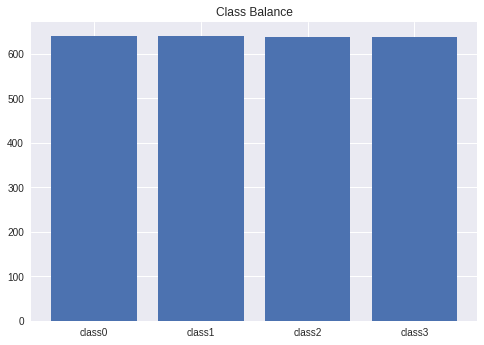

In [11]:
c0, c1, c2, c3 = 0,0,0,0
for c in y:
    if c == 0:
        c0+=1
    elif c == 1:
        c1+=1
    elif c == 2:
        c2+=1
    elif c == 3:
        c3+=1
        
data = {'class0':c0, 'class1':c1, 'class2':c2, 'class3':c3}
print((c0+c1+c2+c3) == X.shape[0])
names = list(data.keys())
values = list(data.values())
plt.bar(names,values)
plt.title("Class Balance")
    

# Data Manipulation 
Tensor dimensions were adjusted to fit pytorch's LSTM requirements, and data was split into train and test groups.

In [0]:
X = torch.FloatTensor(X)
X = torch.squeeze(X)
X = X.numpy()
#samples, features, time -> samples, time, features
X = np.transpose(X, (0,2,1))#batch x time x features 



from sklearn.model_selection import StratifiedShuffleSplit

# use strat. shuffle split to get indices for test and training data 
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
sss.get_n_splits(X, y)

# take the indices generated by stratified shuffle split and make the test and training datasets
for train_index, test_index in sss.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    

In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2046, 1000, 22) (2046,)
(512, 1000, 22) (512,)


In [20]:
from sklearn.preprocessing import MultiLabelBinarizer
print(X.shape)
print(y.shape)

def create_one_hot(vec):
    vec_new = []
    for val in vec:
        if val == 0:
            vec_new.append([1,0,0,0])
        elif val == 1:
            vec_new.append([0,1,0,0])
        elif val == 2: 
            vec_new.append([0,0,1,0])
        elif val == 3:
            vec_new.append([0,0,0,1])

    return vec_new

y_test_new = np.array(create_one_hot(y_test))
y_train_new = np.array(create_one_hot(y_train))
y_total_new = np.array(create_one_hot(y))

print(len(y_train_new) == len(y_train))
print(len(y_test_new) == len(y_test))



(2558, 22, 1000, 1)
(2558,)
True
True


In [0]:

def eval_model(rnn, data_loader):
    # Test the Model
    correct, total = 0, 0
    for batch_X, batch_y in data_loader:
        points = Variable(torch.from_numpy(batch_X))
        labels = torch.from_numpy(batch_y)
        if next(rnn.parameters()).is_cuda:
            points, labels = points.cuda(), labels.cuda()
        outputs = rnn(points)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    return correct / total
  
def dataloader(train_dataset, batch_size):
    # for i, (images, labels) in enumerate(train_loader)
    X, y = train_dataset
    xA, xD = pywt.dwt(X, 'db1')
    X = xA
    
    arr = np.arange(X.shape[0])
    np.random.shuffle(arr)
    batches, batch_x, batch_y = [], [], []
    for a, i in enumerate(arr):
        batch_x.append(X[i])
        batch_y.append(y[i])
        if a == len(arr)-1 or len(batch_x) == batch_size:
            batches.append((np.stack(batch_x).astype(np.float32), np.array(batch_y).astype(int)))
            batch_x, batch_y = [], []
    return batches
  
#test loader
test_loader = dataloader((X_test, y_test), batch_size=batch_size)




# RNN
Basic RNN (LSTM and GRU) can be tested here, since the intialization of the RNN can take either 'GRU' or 'LSTM' values.

In [0]:

class RNN(nn.Module):
    def __init__(self, rnn_type, input_size, hidden_size=100, num_layers=10, num_classes=4, dropout=0):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = getattr(nn, rnn_type)(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial states
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda()
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda()

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)#(h0, c0))

        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out
      


In [24]:
#create the model
use_cuda = True
rnn = RNN('GRU', input_size=11, hidden_size=100, num_layers=2, num_classes=4)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
  print("using CUDA")
  rnn, criterion = rnn.cuda(), criterion.cuda() 
  
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate, weight_decay=1e-5)
  
          

using CUDA


In [25]:
# Train the Model
num_epochs = 50

i = 0 # updates
best_test_acc = 0.0
for epoch in range(num_epochs):
    # Generate random batches every epoch
    train_loader = dataloader((X_train, y_train), batch_size=batch_size)
    for batch_X, batch_y in train_loader:

        points = Variable(torch.from_numpy(batch_X))
        labels = Variable(torch.from_numpy(batch_y))

        if torch.cuda.is_available():
            points, labels = points.cuda(), labels.cuda()

        # Forward + Backward + Optimize
        optimizer.zero_grad()
#        import pdb; pdb.set_trace()

        outputs = rnn(points)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 0: # every 100 updates, evaluate on test set
            print ('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, loss.data[0]))
            print("training accuracy = %.4f" % eval_model(rnn, train_loader))
            test_acc = eval_model(rnn, test_loader)
            print("test accuracy = %.4f" % test_acc)
            if test_acc > best_test_acc:
                print ("best test accuracy found")
                best_test_acc = test_acc
                torch.save(rnn.state_dict(), 'rnn_best.pkl')
        i += 1

Epoch [1/50], Loss: 1.3882
training accuracy = 0.2478
test accuracy = 0.2168
best test accuracy found
Epoch [5/50], Loss: 1.3057
training accuracy = 0.3998
test accuracy = 0.2461
best test accuracy found
Epoch [10/50], Loss: 1.1844
training accuracy = 0.5132
test accuracy = 0.2480
best test accuracy found
Epoch [15/50], Loss: 0.9326
training accuracy = 0.6779
test accuracy = 0.2539
best test accuracy found
Epoch [20/50], Loss: 0.5641
training accuracy = 0.8045
test accuracy = 0.2422
Epoch [24/50], Loss: 0.2846
training accuracy = 0.9638
test accuracy = 0.2441
Epoch [29/50], Loss: 0.0735
training accuracy = 0.9976
test accuracy = 0.2422
Epoch [34/50], Loss: 0.0085
training accuracy = 1.0000
test accuracy = 0.2520
Epoch [39/50], Loss: 0.0036
training accuracy = 1.0000
test accuracy = 0.2461
Epoch [43/50], Loss: 0.0031
training accuracy = 1.0000
test accuracy = 0.2559
best test accuracy found
Epoch [48/50], Loss: 0.0019
training accuracy = 1.0000
test accuracy = 0.2559


Basic RNNs, including variations of the LSTM and GRU, could not perform above 0.25, yet would easily overfit the data. Adding more cells or depth did not help this at all. 

# Convolutional RNN
Conv layer for feature selection and LSTM for sequence dependencies.

Adding in more cells and layers to the RNN-based models, such as the GRU and LSTM, resulted in faster and faster overfitting without higher validation accuracy. The more complex models could quickly memorize the data but were unable to generalize. The intuition behind this was that the models were simply memorizing the input signals rather than learning activations on the specific features that pertain to an output class. This lead us to try and investigate better methods of feature selection, and inspired the use of a conv layer to do feature selection before passing the output to an RNN.

In [8]:
from keras.models import Sequential 
from keras.layers import Dense, Conv2D, Convolution2D, InputLayer, MaxPooling2D, MaxPooling1D, GRU, LSTM
from keras.layers import Activation, Flatten, TimeDistributed, Dropout
from keras.callbacks import ReduceLROnPlateau, Callback
from keras.models import load_model

import tensorflow as tf
import keras



Using TensorFlow backend.


## GPU Setup

In [0]:
keras.backend.clear_session()

In [9]:
#GPU setup
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())


from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15952453337389898940
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11297803469
locality {
  bus_id: 1
}
incarnation: 7348200981809306989
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
config = tf.ConfigProto( device_count = {'GPU': 0} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

## Auxilary Functions

In [0]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [12]:
shape = X.shape
print(shape)
input_shape = X.shape

#Keras requires NHWC for tf backend
#I have NCHW 
#0 1 2 3 -> 0 2 3 1
X = np.transpose(X, (0,2,3,1))
print(X.shape)

(2558, 1, 25, 1000)
(2558, 25, 1000, 1)


In [13]:

from sklearn.model_selection import StratifiedShuffleSplit

# use strat. shuffle split to get indices for test and training data 
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
sss.get_n_splits(X, y)

# take the indices generated by stratified shuffle split and make the test and training datasets
for train_index, test_index in sss.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
print(X_train.shape)

(2046, 25, 1000, 1)


In [14]:
def create_one_hot(vec):
    vec_new = []
    for val in vec:
        if val == 0:
            vec_new.append([1,0,0,0])
        elif val == 1:
            vec_new.append([0,1,0,0])
        elif val == 2: 
            vec_new.append([0,0,1,0])
        elif val == 3:
            vec_new.append([0,0,0,1])

    return vec_new


y_test_new = np.array(create_one_hot(y_test))
y_train_new = np.array(create_one_hot(y_train))
y_total_new = np.array(create_one_hot(y))

print(len(y_train_new) == len(y_train))
print(len(y_test_new) == len(y_test))

True
True


## Model Implementations

### Single Conv Layer + LSTM 
Using 32 filters. <br>
Baseline validation accuracy settles at around 0.4 using only EEG channels, with a peak of 0.46.
Validation accuracy with EEG+EOG settles at around 0.61, with a peak of 0.64.

In [15]:
num_filters=32
kernel=(3,3)
output_classes=4


model1=Sequential()
#The input generated by the generator 
#should have shape:[batch_size, num_timesteps, img_width, img_height, img_channels].
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(22,1000,1)))
model1.add(TimeDistributed(Activation("relu")))
model1.add(TimeDistributed(MaxPooling1D(pool_size=(2))))
model1.add(TimeDistributed(Flatten()))
model1.add(TimeDistributed(Dropout(0.25)))
model1.add(LSTM(units=100))
model1.add(Dense(output_classes))
model1.add(Activation('softmax'))


model1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model1.fit(X, y_total_new, batch_size=50, epochs=50, validation_split=0.2)
model1.save('model1.h5')



Train on 2046 samples, validate on 512 samples
Epoch 1/50
2046/2046 [==============================] - 133s 65ms/step - loss: 1.4087 - acc: 0.2884 - val_loss: 1.3850 - val_acc: 0.2754
Epoch 2/50
2046/2046 [==============================] - 133s 65ms/step - loss: 1.3616 - acc: 0.3558 - val_loss: 1.3715 - val_acc: 0.3086
Epoch 3/50
2046/2046 [==============================] - 133s 65ms/step - loss: 1.3511 - acc: 0.3617 - val_loss: 1.3870 - val_acc: 0.3086
Epoch 4/50
2046/2046 [==============================] - 132s 65ms/step - loss: 1.3350 - acc: 0.3817 - val_loss: 1.3827 - val_acc: 0.2695
Epoch 5/50
2046/2046 [==============================] - 133s 65ms/step - loss: 1.3434 - acc: 0.3534 - val_loss: 1.3755 - val_acc: 0.3027
Epoch 6/50
 750/2046 [=========>....................] - ETA: 1:18 - loss: 1.3313 - acc: 0.3920

2046/2046 [==============================] - 132s 65ms/step - loss: 1.3371 - acc: 0.3837 - val_loss: 1.3668 - val_acc: 0.3066
Epoch 7/50
2046/2046 [==============================] - 133s 65ms/step - loss: 1.3392 - acc: 0.3910 - val_loss: 1.3747 - val_acc: 0.3105
Epoch 8/50
2046/2046 [==============================] - 132s 65ms/step - loss: 1.3188 - acc: 0.4164 - val_loss: 1.3730 - val_acc: 0.3223
Epoch 9/50
2046/2046 [==============================] - 133s 65ms/step - loss: 1.2839 - acc: 0.4521 - val_loss: 1.3603 - val_acc: 0.2988
Epoch 10/50
2046/2046 [==============================] - 133s 65ms/step - loss: 1.2714 - acc: 0.4541 - val_loss: 1.3565 - val_acc: 0.3340
Epoch 11/50
1650/2046 [=======================>......] - ETA: 24s - loss: 1.2336 - acc: 0.5000

2046/2046 [==============================] - 133s 65ms/step - loss: 1.2347 - acc: 0.4976 - val_loss: 1.3353 - val_acc: 0.3516
Epoch 12/50
2046/2046 [==============================] - 132s 64ms/step - loss: 1.2071 - acc: 0.5196 - val_loss: 1.3383 - val_acc: 0.3164
Epoch 13/50
2046/2046 [==============================] - 130s 64ms/step - loss: 1.1766 - acc: 0.5640 - val_loss: 1.3320 - val_acc: 0.3535
Epoch 14/50
2046/2046 [==============================] - 131s 64ms/step - loss: 1.1466 - acc: 0.5650 - val_loss: 1.3139 - val_acc: 0.3809
Epoch 15/50
2046/2046 [==============================] - 131s 64ms/step - loss: 1.1210 - acc: 0.5904 - val_loss: 1.3377 - val_acc: 0.3613
Epoch 16/50
1700/2046 [=======================>......] - ETA: 20s - loss: 1.1088 - acc: 0.5729

2046/2046 [==============================] - 131s 64ms/step - loss: 1.1060 - acc: 0.5782 - val_loss: 1.3158 - val_acc: 0.3691
Epoch 17/50
2046/2046 [==============================] - 131s 64ms/step - loss: 1.0684 - acc: 0.6134 - val_loss: 1.3209 - val_acc: 0.3848
Epoch 18/50
2046/2046 [==============================] - 131s 64ms/step - loss: 1.0312 - acc: 0.6437 - val_loss: 1.3286 - val_acc: 0.3926
Epoch 19/50
2046/2046 [==============================] - 131s 64ms/step - loss: 1.0155 - acc: 0.6706 - val_loss: 1.3426 - val_acc: 0.3613
Epoch 20/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.9884 - acc: 0.6896 - val_loss: 1.3367 - val_acc: 0.3770
Epoch 21/50
1700/2046 [=======================>......] - ETA: 20s - loss: 0.9819 - acc: 0.6812

2046/2046 [==============================] - 130s 64ms/step - loss: 0.9823 - acc: 0.6764 - val_loss: 1.3458 - val_acc: 0.3613
Epoch 22/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.9349 - acc: 0.7009 - val_loss: 1.3682 - val_acc: 0.3477
Epoch 23/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.9030 - acc: 0.7082 - val_loss: 1.3636 - val_acc: 0.3789
Epoch 24/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.8930 - acc: 0.7297 - val_loss: 1.3864 - val_acc: 0.3652
Epoch 25/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.8675 - acc: 0.7380 - val_loss: 1.3749 - val_acc: 0.3770
Epoch 26/50
1700/2046 [=======================>......] - ETA: 20s - loss: 0.8416 - acc: 0.7359

2046/2046 [==============================] - 131s 64ms/step - loss: 0.8445 - acc: 0.7346 - val_loss: 1.4074 - val_acc: 0.3711
Epoch 27/50
2046/2046 [==============================] - 132s 64ms/step - loss: 0.8251 - acc: 0.7502 - val_loss: 1.3904 - val_acc: 0.3633
Epoch 28/50
2046/2046 [==============================] - 132s 64ms/step - loss: 0.7980 - acc: 0.7493 - val_loss: 1.4016 - val_acc: 0.3672
Epoch 29/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.7691 - acc: 0.7727 - val_loss: 1.4097 - val_acc: 0.3730
Epoch 30/50
2046/2046 [==============================] - 132s 64ms/step - loss: 0.7478 - acc: 0.7967 - val_loss: 1.4122 - val_acc: 0.3730
Epoch 31/50
1700/2046 [=======================>......] - ETA: 20s - loss: 0.7346 - acc: 0.7894

2046/2046 [==============================] - 133s 65ms/step - loss: 0.7346 - acc: 0.7893 - val_loss: 1.4363 - val_acc: 0.3770
Epoch 32/50
2046/2046 [==============================] - 133s 65ms/step - loss: 0.7082 - acc: 0.8069 - val_loss: 1.4455 - val_acc: 0.3652
Epoch 33/50
2046/2046 [==============================] - 133s 65ms/step - loss: 0.6878 - acc: 0.8113 - val_loss: 1.4839 - val_acc: 0.3828
Epoch 34/50
2046/2046 [==============================] - 132s 65ms/step - loss: 0.6786 - acc: 0.8099 - val_loss: 1.4386 - val_acc: 0.3750
Epoch 35/50
2046/2046 [==============================] - 132s 64ms/step - loss: 0.6753 - acc: 0.8250 - val_loss: 1.4538 - val_acc: 0.3926
Epoch 36/50
1700/2046 [=======================>......] - ETA: 20s - loss: 0.6724 - acc: 0.8147

2046/2046 [==============================] - 133s 65ms/step - loss: 0.6663 - acc: 0.8221 - val_loss: 1.5173 - val_acc: 0.3535
Epoch 37/50
2046/2046 [==============================] - 132s 65ms/step - loss: 0.6468 - acc: 0.8304 - val_loss: 1.5311 - val_acc: 0.3555
Epoch 38/50
2046/2046 [==============================] - 132s 64ms/step - loss: 0.6497 - acc: 0.8074 - val_loss: 1.5379 - val_acc: 0.3379
Epoch 39/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.5961 - acc: 0.8519 - val_loss: 1.5545 - val_acc: 0.3594
Epoch 40/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.5817 - acc: 0.8519 - val_loss: 1.5689 - val_acc: 0.3594
Epoch 41/50
1700/2046 [=======================>......] - ETA: 20s - loss: 0.5613 - acc: 0.8653

2046/2046 [==============================] - 131s 64ms/step - loss: 0.5652 - acc: 0.8573 - val_loss: 1.5428 - val_acc: 0.3574
Epoch 42/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.5605 - acc: 0.8631 - val_loss: 1.5256 - val_acc: 0.3867
Epoch 43/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.5512 - acc: 0.8612 - val_loss: 1.5405 - val_acc: 0.3516
Epoch 44/50
2046/2046 [==============================] - 132s 64ms/step - loss: 0.5406 - acc: 0.8705 - val_loss: 1.5733 - val_acc: 0.3652
Epoch 45/50
2046/2046 [==============================] - 130s 64ms/step - loss: 0.5102 - acc: 0.8768 - val_loss: 1.5778 - val_acc: 0.3496
Epoch 46/50
1700/2046 [=======================>......] - ETA: 20s - loss: 0.5034 - acc: 0.8794

2046/2046 [==============================] - 131s 64ms/step - loss: 0.4993 - acc: 0.8798 - val_loss: 1.6096 - val_acc: 0.3535
Epoch 47/50
2046/2046 [==============================] - 133s 65ms/step - loss: 0.4895 - acc: 0.8832 - val_loss: 1.6306 - val_acc: 0.3535
Epoch 48/50
2046/2046 [==============================] - 133s 65ms/step - loss: 0.4742 - acc: 0.8847 - val_loss: 1.6243 - val_acc: 0.3340
Epoch 49/50
2046/2046 [==============================] - 133s 65ms/step - loss: 0.4695 - acc: 0.8866 - val_loss: 1.6591 - val_acc: 0.3613
Epoch 50/50
2046/2046 [==============================] - 133s 65ms/step - loss: 0.4465 - acc: 0.8935 - val_loss: 1.6621 - val_acc: 0.3535


### Two Conv Layers + LSTM
Validation accuracy marginally better than single conv layer at 0.41. Peak was 0.42.

In [16]:
num_filters=32
kernel=(3,3)
output_classes=4


model3=Sequential()
#The input generated by the generator 
#should have shape:[batch_size, num_timesteps, img_width, img_height, img_channels].
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(22,1000,1)))
model3.add(TimeDistributed(Activation("relu")))
model3.add(TimeDistributed(MaxPooling1D(pool_size=(2))))
model3.add(Conv2D(32, (3, 3), activation='relu'))
model3.add(TimeDistributed(Activation("relu")))
model3.add(TimeDistributed(MaxPooling1D(pool_size=(2))))
model3.add(TimeDistributed(Flatten()))
model3.add(TimeDistributed(Dropout(0.25)))

model3.add(LSTM(units=100))

model3.add(Dense(output_classes))
model3.add(Activation("softmax"))

# Set a learning rate annealer
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                         #   patience=3, 
                                          #  verbose=1, 
                                          #  factor=0.5, 
                                          #  min_lr=0.00001)
model3.summary()
model3.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model3.fit(X, y_total_new, batch_size=50, epochs=50, validation_split=0.2)
model3.save('model3.h5')




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 20, 998, 32)       320       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 998, 32)       0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 499, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 497, 32)       9248      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 497, 32)       0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 18, 248, 32)       0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 18, 7936)          0         
__________

2046/2046 [==============================] - 124s 61ms/step - loss: 1.3859 - acc: 0.2581 - val_loss: 1.3864 - val_acc: 0.2422
Epoch 3/50
2046/2046 [==============================] - 125s 61ms/step - loss: 1.3849 - acc: 0.2419 - val_loss: 1.3794 - val_acc: 0.2734
Epoch 4/50
2046/2046 [==============================] - 125s 61ms/step - loss: 1.3704 - acc: 0.3206 - val_loss: 1.3792 - val_acc: 0.2852
Epoch 5/50
2046/2046 [==============================] - 124s 61ms/step - loss: 1.3708 - acc: 0.3099 - val_loss: 1.3762 - val_acc: 0.2949
Epoch 6/50
2046/2046 [==============================] - 125s 61ms/step - loss: 1.3624 - acc: 0.3421 - val_loss: 1.3830 - val_acc: 0.2852
Epoch 7/50
1600/2046 [======================>.......] - ETA: 25s - loss: 1.3544 - acc: 0.3625

2046/2046 [==============================] - 124s 61ms/step - loss: 1.3546 - acc: 0.3578 - val_loss: 1.3741 - val_acc: 0.3008
Epoch 8/50
2046/2046 [==============================] - 118s 57ms/step - loss: 1.3488 - acc: 0.3343 - val_loss: 1.3838 - val_acc: 0.2559
Epoch 9/50
2046/2046 [==============================] - 117s 57ms/step - loss: 1.3360 - acc: 0.3827 - val_loss: 1.3690 - val_acc: 0.3086
Epoch 10/50
2046/2046 [==============================] - 121s 59ms/step - loss: 1.3263 - acc: 0.3900 - val_loss: 1.3734 - val_acc: 0.3145
Epoch 11/50
2046/2046 [==============================] - 124s 61ms/step - loss: 1.3112 - acc: 0.4062 - val_loss: 1.3681 - val_acc: 0.3047
Epoch 12/50
1750/2046 [========================>.....] - ETA: 16s - loss: 1.3065 - acc: 0.3783

2046/2046 [==============================] - 125s 61ms/step - loss: 1.3032 - acc: 0.3851 - val_loss: 1.3624 - val_acc: 0.3203
Epoch 13/50
2046/2046 [==============================] - 124s 61ms/step - loss: 1.2844 - acc: 0.4487 - val_loss: 1.3557 - val_acc: 0.3184
Epoch 14/50
2046/2046 [==============================] - 124s 61ms/step - loss: 1.2628 - acc: 0.4863 - val_loss: 1.3531 - val_acc: 0.3262
Epoch 15/50
2046/2046 [==============================] - 122s 60ms/step - loss: 1.2514 - acc: 0.4888 - val_loss: 1.3531 - val_acc: 0.3184
Epoch 16/50
2046/2046 [==============================] - 122s 60ms/step - loss: 1.1997 - acc: 0.5738 - val_loss: 1.3422 - val_acc: 0.3574
Epoch 17/50
1700/2046 [=======================>......] - ETA: 18s - loss: 1.1568 - acc: 0.6271

2046/2046 [==============================] - 118s 58ms/step - loss: 1.1582 - acc: 0.6241 - val_loss: 1.3454 - val_acc: 0.3457
Epoch 18/50
2046/2046 [==============================] - 120s 59ms/step - loss: 1.1222 - acc: 0.6574 - val_loss: 1.3261 - val_acc: 0.3867
Epoch 19/50
2046/2046 [==============================] - 122s 60ms/step - loss: 1.0771 - acc: 0.7009 - val_loss: 1.3269 - val_acc: 0.3770
Epoch 20/50
2046/2046 [==============================] - 123s 60ms/step - loss: 1.0341 - acc: 0.7292 - val_loss: 1.3173 - val_acc: 0.3867
Epoch 21/50
2046/2046 [==============================] - 123s 60ms/step - loss: 0.9978 - acc: 0.7410 - val_loss: 1.3350 - val_acc: 0.3633
Epoch 22/50
1700/2046 [=======================>......] - ETA: 19s - loss: 0.9485 - acc: 0.7606

2046/2046 [==============================] - 123s 60ms/step - loss: 0.9480 - acc: 0.7605 - val_loss: 1.3489 - val_acc: 0.3555
Epoch 23/50
2046/2046 [==============================] - 122s 60ms/step - loss: 0.8947 - acc: 0.8074 - val_loss: 1.3477 - val_acc: 0.3711
Epoch 24/50
2046/2046 [==============================] - 122s 60ms/step - loss: 0.8300 - acc: 0.8016 - val_loss: 1.3386 - val_acc: 0.3965
Epoch 25/50
2046/2046 [==============================] - 122s 60ms/step - loss: 0.7638 - acc: 0.8436 - val_loss: 1.3388 - val_acc: 0.3809
Epoch 26/50
2046/2046 [==============================] - 122s 60ms/step - loss: 0.6962 - acc: 0.8622 - val_loss: 1.3568 - val_acc: 0.3965
Epoch 27/50
1700/2046 [=======================>......] - ETA: 19s - loss: 0.6405 - acc: 0.8771

2046/2046 [==============================] - 122s 60ms/step - loss: 0.6454 - acc: 0.8715 - val_loss: 1.3944 - val_acc: 0.3711
Epoch 28/50
2046/2046 [==============================] - 123s 60ms/step - loss: 0.5831 - acc: 0.8954 - val_loss: 1.3987 - val_acc: 0.3770
Epoch 29/50
2046/2046 [==============================] - 122s 60ms/step - loss: 0.5386 - acc: 0.9066 - val_loss: 1.4288 - val_acc: 0.3672
Epoch 30/50
2046/2046 [==============================] - 122s 60ms/step - loss: 0.4905 - acc: 0.9247 - val_loss: 1.4387 - val_acc: 0.3672
Epoch 31/50
2046/2046 [==============================] - 122s 60ms/step - loss: 0.4553 - acc: 0.9257 - val_loss: 1.4506 - val_acc: 0.3770
Epoch 32/50
1700/2046 [=======================>......] - ETA: 19s - loss: 0.4135 - acc: 0.9412

2046/2046 [==============================] - 123s 60ms/step - loss: 0.4113 - acc: 0.9418 - val_loss: 1.4878 - val_acc: 0.3730
Epoch 33/50
2046/2046 [==============================] - 122s 60ms/step - loss: 0.3790 - acc: 0.9448 - val_loss: 1.4778 - val_acc: 0.3848
Epoch 34/50
2046/2046 [==============================] - 123s 60ms/step - loss: 0.3545 - acc: 0.9516 - val_loss: 1.5157 - val_acc: 0.3789
Epoch 35/50
2046/2046 [==============================] - 123s 60ms/step - loss: 0.3262 - acc: 0.9477 - val_loss: 1.5669 - val_acc: 0.3750
Epoch 36/50
2046/2046 [==============================] - 123s 60ms/step - loss: 0.2985 - acc: 0.9541 - val_loss: 1.6202 - val_acc: 0.3437
Epoch 37/50
1700/2046 [=======================>......] - ETA: 19s - loss: 0.2761 - acc: 0.9582

2046/2046 [==============================] - 123s 60ms/step - loss: 0.2790 - acc: 0.9570 - val_loss: 1.6154 - val_acc: 0.3477
Epoch 38/50
2046/2046 [==============================] - 122s 60ms/step - loss: 0.2519 - acc: 0.9629 - val_loss: 1.6537 - val_acc: 0.3652
Epoch 39/50
2046/2046 [==============================] - 122s 60ms/step - loss: 0.2268 - acc: 0.9697 - val_loss: 1.7046 - val_acc: 0.3535
Epoch 40/50
2046/2046 [==============================] - 123s 60ms/step - loss: 0.2177 - acc: 0.9697 - val_loss: 1.6707 - val_acc: 0.3613
Epoch 41/50
2046/2046 [==============================] - 124s 61ms/step - loss: 0.2063 - acc: 0.9721 - val_loss: 1.7240 - val_acc: 0.3574
Epoch 42/50
1700/2046 [=======================>......] - ETA: 19s - loss: 0.1864 - acc: 0.9765

2046/2046 [==============================] - 124s 61ms/step - loss: 0.1857 - acc: 0.9775 - val_loss: 1.7423 - val_acc: 0.3711
Epoch 43/50
2046/2046 [==============================] - 123s 60ms/step - loss: 0.1771 - acc: 0.9780 - val_loss: 1.7118 - val_acc: 0.3652
Epoch 44/50
2046/2046 [==============================] - 122s 60ms/step - loss: 0.1638 - acc: 0.9765 - val_loss: 1.7944 - val_acc: 0.3848
Epoch 45/50
2046/2046 [==============================] - 122s 60ms/step - loss: 0.1497 - acc: 0.9829 - val_loss: 1.7756 - val_acc: 0.3809
Epoch 46/50
2046/2046 [==============================] - 123s 60ms/step - loss: 0.1458 - acc: 0.9775 - val_loss: 1.7827 - val_acc: 0.3672
Epoch 47/50
1700/2046 [=======================>......] - ETA: 19s - loss: 0.1349 - acc: 0.9835

2046/2046 [==============================] - 122s 60ms/step - loss: 0.1339 - acc: 0.9848 - val_loss: 1.8443 - val_acc: 0.3535
Epoch 48/50
2046/2046 [==============================] - 122s 60ms/step - loss: 0.1220 - acc: 0.9848 - val_loss: 1.7832 - val_acc: 0.3965
Epoch 49/50
2046/2046 [==============================] - 122s 60ms/step - loss: 0.1095 - acc: 0.9888 - val_loss: 1.9353 - val_acc: 0.3594
Epoch 50/50
2046/2046 [==============================] - 122s 60ms/step - loss: 0.1014 - acc: 0.9922 - val_loss: 1.9096 - val_acc: 0.3750


### Two Conv Layers + 2 LSTMs
Peak validation accuracy 0f 0.33, average 0.3. Seems like adding more LSTMs isn't the way to go.

In [17]:
num_filters=32
kernel=(3,3)
output_classes=4


model4=Sequential()
#The input generated by the generator 
#should have shape:[batch_size, num_timesteps, img_width, img_height, img_channels].
model4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(22,1000,1)))
model4.add(TimeDistributed(Activation("relu")))
model4.add(TimeDistributed(MaxPooling1D(pool_size=(2))))
model4.add(Conv2D(32, (3, 3), activation='relu'))
model4.add(TimeDistributed(Activation("relu")))
model4.add(TimeDistributed(MaxPooling1D(pool_size=(2))))
model4.add(TimeDistributed(Flatten()))
model4.add(TimeDistributed(Dropout(0.25)))

model4.add(LSTM(units=100, return_sequences=True))
model4.add(LSTM(units=100))

model4.add(Dense(output_classes))
model4.add(Activation("softmax"))

# Set a learning rate annealer
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                         #   patience=3, 
                                          #  verbose=1, 
                                          #  factor=0.5, 
                                          #  min_lr=0.00001)
model4.summary()
model4.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model4.fit(X, y_total_new, batch_size=50, epochs=50, validation_split=0.2)
model4.save('model4.h5')





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 20, 998, 32)       320       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 20, 998, 32)       0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 20, 499, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 497, 32)       9248      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 18, 497, 32)       0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 18, 248, 32)       0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 18, 7936)          0         
__________

2046/2046 [==============================] - 124s 60ms/step - loss: 1.3795 - acc: 0.2791 - val_loss: 1.3788 - val_acc: 0.3262
Epoch 3/50
2046/2046 [==============================] - 123s 60ms/step - loss: 1.3468 - acc: 0.3583 - val_loss: 1.3862 - val_acc: 0.2910
Epoch 4/50
2046/2046 [==============================] - 123s 60ms/step - loss: 1.2965 - acc: 0.4027 - val_loss: 1.4556 - val_acc: 0.2754
Epoch 5/50
2046/2046 [==============================] - 123s 60ms/step - loss: 1.2341 - acc: 0.4370 - val_loss: 1.4640 - val_acc: 0.3203
Epoch 6/50
2046/2046 [==============================] - 123s 60ms/step - loss: 1.1746 - acc: 0.4932 - val_loss: 1.4799 - val_acc: 0.2988
Epoch 7/50
1600/2046 [======================>.......] - ETA: 25s - loss: 1.0595 - acc: 0.5681

2046/2046 [==============================] - 123s 60ms/step - loss: 1.0675 - acc: 0.5562 - val_loss: 1.6261 - val_acc: 0.2813
Epoch 8/50
2046/2046 [==============================] - 124s 60ms/step - loss: 0.9643 - acc: 0.6065 - val_loss: 1.6388 - val_acc: 0.2930
Epoch 9/50
2046/2046 [==============================] - 123s 60ms/step - loss: 0.8083 - acc: 0.6745 - val_loss: 1.8381 - val_acc: 0.3105
Epoch 10/50
2046/2046 [==============================] - 123s 60ms/step - loss: 0.6633 - acc: 0.7595 - val_loss: 2.0192 - val_acc: 0.2773
Epoch 11/50
2046/2046 [==============================] - 124s 60ms/step - loss: 0.4556 - acc: 0.8524 - val_loss: 2.3075 - val_acc: 0.2715
Epoch 12/50
1750/2046 [========================>.....] - ETA: 16s - loss: 0.3251 - acc: 0.8949

2046/2046 [==============================] - 124s 60ms/step - loss: 0.3333 - acc: 0.8925 - val_loss: 2.4827 - val_acc: 0.3008
Epoch 13/50
2046/2046 [==============================] - 124s 61ms/step - loss: 0.2485 - acc: 0.9262 - val_loss: 3.0109 - val_acc: 0.2969
Epoch 14/50
2046/2046 [==============================] - 124s 60ms/step - loss: 0.1709 - acc: 0.9457 - val_loss: 3.1885 - val_acc: 0.2871
Epoch 15/50
2046/2046 [==============================] - 124s 60ms/step - loss: 0.1356 - acc: 0.9585 - val_loss: 3.1448 - val_acc: 0.2559
Epoch 16/50
2046/2046 [==============================] - 126s 61ms/step - loss: 0.0876 - acc: 0.9717 - val_loss: 3.7595 - val_acc: 0.2910
Epoch 17/50
1700/2046 [=======================>......] - ETA: 19s - loss: 0.1197 - acc: 0.9612

2046/2046 [==============================] - 125s 61ms/step - loss: 0.1259 - acc: 0.9599 - val_loss: 3.3667 - val_acc: 0.2793
Epoch 18/50
2046/2046 [==============================] - 125s 61ms/step - loss: 0.1123 - acc: 0.9668 - val_loss: 3.1581 - val_acc: 0.2910
Epoch 19/50
2046/2046 [==============================] - 126s 61ms/step - loss: 0.0656 - acc: 0.9804 - val_loss: 3.8341 - val_acc: 0.2598
Epoch 20/50
2046/2046 [==============================] - 126s 62ms/step - loss: 0.0563 - acc: 0.9800 - val_loss: 3.5156 - val_acc: 0.2734
Epoch 21/50
2046/2046 [==============================] - 126s 62ms/step - loss: 0.0452 - acc: 0.9844 - val_loss: 3.8702 - val_acc: 0.2813
Epoch 22/50
1700/2046 [=======================>......] - ETA: 19s - loss: 0.0369 - acc: 0.9900

2046/2046 [==============================] - 126s 62ms/step - loss: 0.0560 - acc: 0.9814 - val_loss: 3.7981 - val_acc: 0.2871
Epoch 23/50
2046/2046 [==============================] - 126s 62ms/step - loss: 0.0630 - acc: 0.9839 - val_loss: 3.6900 - val_acc: 0.2871
Epoch 24/50
2046/2046 [==============================] - 126s 62ms/step - loss: 0.0518 - acc: 0.9839 - val_loss: 4.3199 - val_acc: 0.2793
Epoch 25/50
2046/2046 [==============================] - 126s 62ms/step - loss: 0.0483 - acc: 0.9834 - val_loss: 3.9398 - val_acc: 0.2539
Epoch 26/50
2046/2046 [==============================] - 126s 61ms/step - loss: 0.0507 - acc: 0.9853 - val_loss: 3.7858 - val_acc: 0.2734
Epoch 27/50
1700/2046 [=======================>......] - ETA: 19s - loss: 0.0297 - acc: 0.9894

2046/2046 [==============================] - 126s 61ms/step - loss: 0.0298 - acc: 0.9888 - val_loss: 4.2016 - val_acc: 0.2656
Epoch 28/50
2046/2046 [==============================] - 125s 61ms/step - loss: 0.0319 - acc: 0.9922 - val_loss: 4.1485 - val_acc: 0.2813
Epoch 29/50
2046/2046 [==============================] - 126s 61ms/step - loss: 0.0382 - acc: 0.9883 - val_loss: 3.9012 - val_acc: 0.3008
Epoch 30/50
2046/2046 [==============================] - 125s 61ms/step - loss: 0.0149 - acc: 0.9956 - val_loss: 4.5798 - val_acc: 0.2832
Epoch 31/50
2046/2046 [==============================] - 126s 61ms/step - loss: 0.0263 - acc: 0.9927 - val_loss: 3.9894 - val_acc: 0.2793
Epoch 32/50
1700/2046 [=======================>......] - ETA: 19s - loss: 0.0233 - acc: 0.9941

2046/2046 [==============================] - 126s 61ms/step - loss: 0.0218 - acc: 0.9941 - val_loss: 4.8214 - val_acc: 0.2832
Epoch 33/50
2046/2046 [==============================] - 126s 62ms/step - loss: 0.0320 - acc: 0.9883 - val_loss: 4.1181 - val_acc: 0.2656
Epoch 34/50
2046/2046 [==============================] - 126s 62ms/step - loss: 0.0179 - acc: 0.9941 - val_loss: 4.9574 - val_acc: 0.2734
Epoch 35/50
2046/2046 [==============================] - 126s 62ms/step - loss: 0.0319 - acc: 0.9892 - val_loss: 4.0988 - val_acc: 0.2637
Epoch 36/50
2046/2046 [==============================] - 126s 61ms/step - loss: 0.0261 - acc: 0.9912 - val_loss: 4.5009 - val_acc: 0.2656
Epoch 37/50
1700/2046 [=======================>......] - ETA: 19s - loss: 0.0167 - acc: 0.9941

2046/2046 [==============================] - 126s 61ms/step - loss: 0.0169 - acc: 0.9946 - val_loss: 4.1675 - val_acc: 0.2812
Epoch 38/50
2046/2046 [==============================] - 125s 61ms/step - loss: 0.0160 - acc: 0.9941 - val_loss: 4.4725 - val_acc: 0.2812
Epoch 39/50
2046/2046 [==============================] - 125s 61ms/step - loss: 0.0109 - acc: 0.9961 - val_loss: 4.8100 - val_acc: 0.2813
Epoch 40/50
2046/2046 [==============================] - 125s 61ms/step - loss: 0.0307 - acc: 0.9907 - val_loss: 4.2875 - val_acc: 0.2656
Epoch 41/50
2046/2046 [==============================] - 124s 61ms/step - loss: 0.0190 - acc: 0.9936 - val_loss: 4.6308 - val_acc: 0.2813
Epoch 42/50
1700/2046 [=======================>......] - ETA: 19s - loss: 0.0239 - acc: 0.9924

2046/2046 [==============================] - 125s 61ms/step - loss: 0.0221 - acc: 0.9932 - val_loss: 4.5554 - val_acc: 0.2695
Epoch 43/50
2046/2046 [==============================] - 125s 61ms/step - loss: 0.0205 - acc: 0.9927 - val_loss: 4.5633 - val_acc: 0.2734
Epoch 44/50
2046/2046 [==============================] - 126s 61ms/step - loss: 0.0115 - acc: 0.9976 - val_loss: 4.6229 - val_acc: 0.2852
Epoch 45/50
2046/2046 [==============================] - 126s 62ms/step - loss: 0.0079 - acc: 0.9971 - val_loss: 4.6295 - val_acc: 0.2734
Epoch 46/50
2046/2046 [==============================] - 125s 61ms/step - loss: 0.0032 - acc: 0.9995 - val_loss: 4.9804 - val_acc: 0.2930
Epoch 47/50
1700/2046 [=======================>......] - ETA: 19s - loss: 0.0101 - acc: 0.9971

2046/2046 [==============================] - 125s 61ms/step - loss: 0.0161 - acc: 0.9951 - val_loss: 4.4691 - val_acc: 0.2734
Epoch 48/50
2046/2046 [==============================] - 125s 61ms/step - loss: 0.0248 - acc: 0.9927 - val_loss: 4.4788 - val_acc: 0.2871
Epoch 49/50
2046/2046 [==============================] - 126s 61ms/step - loss: 0.0211 - acc: 0.9936 - val_loss: 4.5775 - val_acc: 0.2656
Epoch 50/50
2046/2046 [==============================] - 125s 61ms/step - loss: 0.0220 - acc: 0.9932 - val_loss: 4.2071 - val_acc: 0.2715


# With EOG channels


### Conv + LSTM
EOG Channels included <br>
Able to obtain an average validation accuracy of 0.57.

In [15]:
num_filters=32
kernel=(3,3)
output_classes=4


model5=Sequential()
#The input generated by the generator 
#should have shape:[batch_size, num_timesteps, img_width, img_height, img_channels].
model5.add(Conv2D(32, (3, 3), activation='relu', input_shape=(25,1000,1)))
model5.add(TimeDistributed(Activation("relu")))
model5.add(TimeDistributed(MaxPooling1D(pool_size=(2))))
model5.add(TimeDistributed(Flatten()))
model5.add(TimeDistributed(Dropout(0.25)))
model5.add(LSTM(units=100))
model5.add(Dense(output_classes))
model5.add(Activation('softmax'))


model5.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model5.fit(X, y_total_new, batch_size=50, epochs=50, validation_split=0.2)
model5.save('model5.h5')




Train on 2046 samples, validate on 512 samples
Epoch 1/50
2046/2046 [==============================] - 143s 70ms/step - loss: 1.3789 - acc: 0.3109 - val_loss: 1.3425 - val_acc: 0.3945
Epoch 2/50
2046/2046 [==============================] - 142s 70ms/step - loss: 1.3018 - acc: 0.4878 - val_loss: 1.2821 - val_acc: 0.5234
Epoch 3/50
2046/2046 [==============================] - 143s 70ms/step - loss: 1.2368 - acc: 0.5738 - val_loss: 1.2299 - val_acc: 0.5195
Epoch 4/50
2046/2046 [==============================] - 143s 70ms/step - loss: 1.1891 - acc: 0.5831 - val_loss: 1.1980 - val_acc: 0.5762
Epoch 5/50
2046/2046 [==============================] - 143s 70ms/step - loss: 1.1178 - acc: 0.6271 - val_loss: 1.1377 - val_acc: 0.6172
Epoch 6/50
 750/2046 [=========>....................] - ETA: 1:24 - loss: 1.0676 - acc: 0.6680

2046/2046 [==============================] - 142s 70ms/step - loss: 1.0757 - acc: 0.6559 - val_loss: 1.1289 - val_acc: 0.5977
Epoch 7/50
2046/2046 [==============================] - 143s 70ms/step - loss: 1.0295 - acc: 0.6769 - val_loss: 1.1184 - val_acc: 0.5918
Epoch 8/50
2046/2046 [==============================] - 142s 70ms/step - loss: 0.9898 - acc: 0.6940 - val_loss: 1.0793 - val_acc: 0.6113
Epoch 9/50
2046/2046 [==============================] - 144s 70ms/step - loss: 0.9239 - acc: 0.7405 - val_loss: 1.0859 - val_acc: 0.5645
Epoch 10/50
2046/2046 [==============================] - 145s 71ms/step - loss: 0.9144 - acc: 0.7224 - val_loss: 1.0807 - val_acc: 0.5664
Epoch 11/50
1650/2046 [=======================>......] - ETA: 26s - loss: 0.8659 - acc: 0.7430

2046/2046 [==============================] - 145s 71ms/step - loss: 0.8641 - acc: 0.7429 - val_loss: 1.1241 - val_acc: 0.5371
Epoch 12/50
2046/2046 [==============================] - 144s 70ms/step - loss: 0.8428 - acc: 0.7527 - val_loss: 1.0763 - val_acc: 0.5586
Epoch 13/50
2046/2046 [==============================] - 145s 71ms/step - loss: 0.8296 - acc: 0.7424 - val_loss: 1.0515 - val_acc: 0.5918
Epoch 14/50
2046/2046 [==============================] - 144s 70ms/step - loss: 0.7892 - acc: 0.7722 - val_loss: 1.0536 - val_acc: 0.5957
Epoch 15/50
2046/2046 [==============================] - 144s 70ms/step - loss: 0.7364 - acc: 0.7928 - val_loss: 1.0416 - val_acc: 0.5723
Epoch 16/50
1700/2046 [=======================>......] - ETA: 22s - loss: 0.6869 - acc: 0.7965

2046/2046 [==============================] - 144s 70ms/step - loss: 0.6829 - acc: 0.8021 - val_loss: 1.0183 - val_acc: 0.5820
Epoch 17/50
2046/2046 [==============================] - 145s 71ms/step - loss: 0.6689 - acc: 0.8069 - val_loss: 1.0782 - val_acc: 0.5586
Epoch 18/50
2046/2046 [==============================] - 145s 71ms/step - loss: 0.6674 - acc: 0.8065 - val_loss: 1.0031 - val_acc: 0.6113
Epoch 19/50
2046/2046 [==============================] - 144s 71ms/step - loss: 0.6183 - acc: 0.8157 - val_loss: 1.0162 - val_acc: 0.5879
Epoch 20/50
2046/2046 [==============================] - 144s 70ms/step - loss: 0.6076 - acc: 0.8294 - val_loss: 1.0788 - val_acc: 0.5645
Epoch 21/50
1700/2046 [=======================>......] - ETA: 22s - loss: 0.5615 - acc: 0.8429

2046/2046 [==============================] - 144s 71ms/step - loss: 0.5694 - acc: 0.8372 - val_loss: 1.0686 - val_acc: 0.5645
Epoch 22/50
2046/2046 [==============================] - 144s 71ms/step - loss: 0.5796 - acc: 0.8358 - val_loss: 1.0841 - val_acc: 0.5625
Epoch 23/50
2046/2046 [==============================] - 144s 70ms/step - loss: 0.5460 - acc: 0.8470 - val_loss: 1.0396 - val_acc: 0.5977
Epoch 24/50
2046/2046 [==============================] - 144s 71ms/step - loss: 0.5163 - acc: 0.8607 - val_loss: 1.0547 - val_acc: 0.5625
Epoch 25/50
2046/2046 [==============================] - 143s 70ms/step - loss: 0.4978 - acc: 0.8744 - val_loss: 1.0585 - val_acc: 0.5781
Epoch 26/50
1700/2046 [=======================>......] - ETA: 22s - loss: 0.4717 - acc: 0.8676

2046/2046 [==============================] - 144s 70ms/step - loss: 0.4817 - acc: 0.8675 - val_loss: 1.0454 - val_acc: 0.5840
Epoch 27/50
2046/2046 [==============================] - 144s 70ms/step - loss: 0.4614 - acc: 0.8744 - val_loss: 1.0683 - val_acc: 0.5957
Epoch 28/50
2046/2046 [==============================] - 144s 70ms/step - loss: 0.4543 - acc: 0.8710 - val_loss: 1.0521 - val_acc: 0.5801
Epoch 29/50
2046/2046 [==============================] - 144s 70ms/step - loss: 0.4532 - acc: 0.8715 - val_loss: 1.0985 - val_acc: 0.5723
Epoch 30/50
2046/2046 [==============================] - 144s 70ms/step - loss: 0.4397 - acc: 0.8783 - val_loss: 1.0929 - val_acc: 0.5645
Epoch 31/50
1700/2046 [=======================>......] - ETA: 22s - loss: 0.4145 - acc: 0.8935

2046/2046 [==============================] - 143s 70ms/step - loss: 0.4183 - acc: 0.8920 - val_loss: 1.0471 - val_acc: 0.5898
Epoch 32/50
2046/2046 [==============================] - 144s 70ms/step - loss: 0.4122 - acc: 0.8900 - val_loss: 1.1032 - val_acc: 0.5723
Epoch 33/50
2046/2046 [==============================] - 144s 70ms/step - loss: 0.4395 - acc: 0.8798 - val_loss: 1.0879 - val_acc: 0.5684
Epoch 34/50
2046/2046 [==============================] - 144s 70ms/step - loss: 0.3805 - acc: 0.8988 - val_loss: 1.1215 - val_acc: 0.5801
Epoch 35/50
2046/2046 [==============================] - 143s 70ms/step - loss: 0.3729 - acc: 0.9003 - val_loss: 1.1046 - val_acc: 0.5820
Epoch 36/50
1700/2046 [=======================>......] - ETA: 22s - loss: 0.3717 - acc: 0.9018

2046/2046 [==============================] - 143s 70ms/step - loss: 0.3712 - acc: 0.8998 - val_loss: 1.0775 - val_acc: 0.5918
Epoch 37/50
2046/2046 [==============================] - 143s 70ms/step - loss: 0.3455 - acc: 0.9179 - val_loss: 1.1002 - val_acc: 0.5723
Epoch 38/50
2046/2046 [==============================] - 142s 69ms/step - loss: 0.3348 - acc: 0.9154 - val_loss: 1.1273 - val_acc: 0.5898
Epoch 39/50
2046/2046 [==============================] - 143s 70ms/step - loss: 0.3297 - acc: 0.9135 - val_loss: 1.1270 - val_acc: 0.5820
Epoch 40/50
2046/2046 [==============================] - 143s 70ms/step - loss: 0.3289 - acc: 0.9164 - val_loss: 1.1629 - val_acc: 0.5742
Epoch 41/50
1700/2046 [=======================>......] - ETA: 22s - loss: 0.3178 - acc: 0.9159

2046/2046 [==============================] - 142s 69ms/step - loss: 0.3238 - acc: 0.9135 - val_loss: 1.1845 - val_acc: 0.5684
Epoch 42/50
2046/2046 [==============================] - 143s 70ms/step - loss: 0.3182 - acc: 0.9228 - val_loss: 1.1477 - val_acc: 0.5664
Epoch 43/50
2046/2046 [==============================] - 143s 70ms/step - loss: 0.3260 - acc: 0.9101 - val_loss: 1.1742 - val_acc: 0.5781
Epoch 44/50
2046/2046 [==============================] - 142s 69ms/step - loss: 0.3042 - acc: 0.9198 - val_loss: 1.2049 - val_acc: 0.5742
Epoch 45/50
2046/2046 [==============================] - 142s 69ms/step - loss: 0.2914 - acc: 0.9238 - val_loss: 1.1578 - val_acc: 0.5723
Epoch 46/50
1700/2046 [=======================>......] - ETA: 22s - loss: 0.3138 - acc: 0.9135

2046/2046 [==============================] - 143s 70ms/step - loss: 0.3061 - acc: 0.9174 - val_loss: 1.1621 - val_acc: 0.5781
Epoch 47/50
2046/2046 [==============================] - 143s 70ms/step - loss: 0.2782 - acc: 0.9257 - val_loss: 1.2153 - val_acc: 0.5762
Epoch 48/50
2046/2046 [==============================] - 143s 70ms/step - loss: 0.2942 - acc: 0.9208 - val_loss: 1.1914 - val_acc: 0.5762
Epoch 49/50
2046/2046 [==============================] - 142s 69ms/step - loss: 0.2804 - acc: 0.9184 - val_loss: 1.1853 - val_acc: 0.5703
Epoch 50/50
2046/2046 [==============================] - 142s 70ms/step - loss: 0.2679 - acc: 0.9262 - val_loss: 1.2433 - val_acc: 0.5684


### Two Conv Layers + LSTM
EOG channels included <br>
Able to obtain a validation accuracy of 0.6 with a 0.62 peak.

In [16]:
num_filters=32
kernel=(3,3)
output_classes=4


model6=Sequential()
#The input generated by the generator 
#should have shape:[batch_size, num_timesteps, img_width, img_height, img_channels].
model6.add(Conv2D(32, (3, 3), activation='relu', input_shape=(25,1000,1)))
model6.add(TimeDistributed(Activation("relu")))
model6.add(TimeDistributed(MaxPooling1D(pool_size=(2))))
model6.add(Conv2D(32, (3, 3), activation='relu'))
model6.add(TimeDistributed(Activation("relu")))
model6.add(TimeDistributed(MaxPooling1D(pool_size=(2))))
model6.add(TimeDistributed(Flatten()))
model6.add(TimeDistributed(Dropout(0.25)))

model6.add(LSTM(units=100))

model6.add(Dense(output_classes))
model6.add(Activation("softmax"))

# Set a learning rate annealer
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                         #   patience=3, 
                                          #  verbose=1, 
                                          #  factor=0.5, 
                                          #  min_lr=0.00001)
model6.summary()
model6.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model6.fit(X, y_total_new, batch_size=50, epochs=50, validation_split=0.2)
model6.save('model6.h5')





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 23, 998, 32)       320       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 23, 998, 32)       0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 23, 499, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 497, 32)       9248      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 21, 497, 32)       0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 21, 248, 32)       0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 21, 7936)          0         
__________

2046/2046 [==============================] - 137s 67ms/step - loss: 1.3387 - acc: 0.4047 - val_loss: 1.3213 - val_acc: 0.3379
Epoch 3/50
2046/2046 [==============================] - 137s 67ms/step - loss: 1.2942 - acc: 0.4159 - val_loss: 1.2855 - val_acc: 0.3750
Epoch 4/50
2046/2046 [==============================] - 138s 67ms/step - loss: 1.2481 - acc: 0.4790 - val_loss: 1.2524 - val_acc: 0.4805
Epoch 5/50
2046/2046 [==============================] - 137s 67ms/step - loss: 1.1539 - acc: 0.6129 - val_loss: 1.1563 - val_acc: 0.5840
Epoch 6/50
2046/2046 [==============================] - 137s 67ms/step - loss: 1.0396 - acc: 0.6813 - val_loss: 1.0818 - val_acc: 0.5762
Epoch 7/50
1600/2046 [======================>.......] - ETA: 27s - loss: 0.9149 - acc: 0.7419

2046/2046 [==============================] - 137s 67ms/step - loss: 0.9053 - acc: 0.7419 - val_loss: 1.0723 - val_acc: 0.5605
Epoch 8/50
2046/2046 [==============================] - 137s 67ms/step - loss: 0.8072 - acc: 0.7713 - val_loss: 1.0177 - val_acc: 0.6074
Epoch 9/50
2046/2046 [==============================] - 137s 67ms/step - loss: 0.7191 - acc: 0.8021 - val_loss: 1.0264 - val_acc: 0.5859
Epoch 10/50
2046/2046 [==============================] - 134s 66ms/step - loss: 0.6249 - acc: 0.8412 - val_loss: 1.0225 - val_acc: 0.5801
Epoch 11/50
2046/2046 [==============================] - 130s 64ms/step - loss: 0.5540 - acc: 0.8661 - val_loss: 1.0229 - val_acc: 0.5762
Epoch 12/50
1750/2046 [========================>.....] - ETA: 17s - loss: 0.4726 - acc: 0.8977

2046/2046 [==============================] - 131s 64ms/step - loss: 0.4842 - acc: 0.8895 - val_loss: 1.0674 - val_acc: 0.5430
Epoch 13/50
2046/2046 [==============================] - 138s 67ms/step - loss: 0.4342 - acc: 0.9022 - val_loss: 1.0052 - val_acc: 0.6055
Epoch 14/50
2046/2046 [==============================] - 136s 66ms/step - loss: 0.3772 - acc: 0.9194 - val_loss: 1.0239 - val_acc: 0.5898
Epoch 15/50
2046/2046 [==============================] - 135s 66ms/step - loss: 0.3316 - acc: 0.9326 - val_loss: 1.0148 - val_acc: 0.5859
Epoch 16/50
2046/2046 [==============================] - 133s 65ms/step - loss: 0.2953 - acc: 0.9404 - val_loss: 1.0376 - val_acc: 0.5840
Epoch 17/50
1700/2046 [=======================>......] - ETA: 21s - loss: 0.2609 - acc: 0.9471

2046/2046 [==============================] - 133s 65ms/step - loss: 0.2572 - acc: 0.9501 - val_loss: 1.0298 - val_acc: 0.6016
Epoch 18/50
2046/2046 [==============================] - 132s 65ms/step - loss: 0.2241 - acc: 0.9594 - val_loss: 1.0707 - val_acc: 0.5840
Epoch 19/50
2046/2046 [==============================] - 132s 64ms/step - loss: 0.2085 - acc: 0.9589 - val_loss: 1.0720 - val_acc: 0.5801
Epoch 20/50
2046/2046 [==============================] - 132s 65ms/step - loss: 0.1962 - acc: 0.9663 - val_loss: 1.0740 - val_acc: 0.5820
Epoch 21/50
2046/2046 [==============================] - 132s 65ms/step - loss: 0.1771 - acc: 0.9697 - val_loss: 1.1161 - val_acc: 0.5801
Epoch 22/50
1700/2046 [=======================>......] - ETA: 20s - loss: 0.1605 - acc: 0.9706

2046/2046 [==============================] - 132s 64ms/step - loss: 0.1625 - acc: 0.9687 - val_loss: 1.0961 - val_acc: 0.5840
Epoch 23/50
2046/2046 [==============================] - 132s 64ms/step - loss: 0.1542 - acc: 0.9697 - val_loss: 1.0867 - val_acc: 0.5918
Epoch 24/50
2046/2046 [==============================] - 132s 64ms/step - loss: 0.1395 - acc: 0.9736 - val_loss: 1.1563 - val_acc: 0.5781
Epoch 25/50
2046/2046 [==============================] - 132s 64ms/step - loss: 0.1327 - acc: 0.9746 - val_loss: 1.1516 - val_acc: 0.6055
Epoch 26/50
2046/2046 [==============================] - 132s 65ms/step - loss: 0.1199 - acc: 0.9790 - val_loss: 1.1817 - val_acc: 0.6094
Epoch 27/50
1700/2046 [=======================>......] - ETA: 20s - loss: 0.1138 - acc: 0.9812

2046/2046 [==============================] - 132s 64ms/step - loss: 0.1121 - acc: 0.9809 - val_loss: 1.1844 - val_acc: 0.5918
Epoch 28/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.1072 - acc: 0.9824 - val_loss: 1.1699 - val_acc: 0.6074
Epoch 29/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.0997 - acc: 0.9814 - val_loss: 1.2425 - val_acc: 0.5645
Epoch 30/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.0932 - acc: 0.9844 - val_loss: 1.2529 - val_acc: 0.5938
Epoch 31/50
2046/2046 [==============================] - 130s 64ms/step - loss: 0.0891 - acc: 0.9844 - val_loss: 1.2217 - val_acc: 0.6016
Epoch 32/50
1700/2046 [=======================>......] - ETA: 20s - loss: 0.0896 - acc: 0.9859

2046/2046 [==============================] - 131s 64ms/step - loss: 0.0912 - acc: 0.9844 - val_loss: 1.2327 - val_acc: 0.6016
Epoch 33/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.0832 - acc: 0.9868 - val_loss: 1.2681 - val_acc: 0.5879
Epoch 34/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.0770 - acc: 0.9868 - val_loss: 1.2354 - val_acc: 0.5879
Epoch 35/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.0691 - acc: 0.9873 - val_loss: 1.2556 - val_acc: 0.5859
Epoch 36/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.0677 - acc: 0.9878 - val_loss: 1.3025 - val_acc: 0.5762
Epoch 37/50
1700/2046 [=======================>......] - ETA: 20s - loss: 0.0639 - acc: 0.9876

2046/2046 [==============================] - 131s 64ms/step - loss: 0.0627 - acc: 0.9878 - val_loss: 1.2884 - val_acc: 0.6016
Epoch 38/50
2046/2046 [==============================] - 130s 64ms/step - loss: 0.0605 - acc: 0.9883 - val_loss: 1.2981 - val_acc: 0.5859
Epoch 39/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.0566 - acc: 0.9892 - val_loss: 1.3622 - val_acc: 0.5957
Epoch 40/50
2046/2046 [==============================] - 131s 64ms/step - loss: 0.0564 - acc: 0.9902 - val_loss: 1.3023 - val_acc: 0.5840
Epoch 41/50
2046/2046 [==============================] - 130s 64ms/step - loss: 0.0569 - acc: 0.9897 - val_loss: 1.3168 - val_acc: 0.6094
Epoch 42/50
1700/2046 [=======================>......] - ETA: 19s - loss: 0.0530 - acc: 0.9912

2046/2046 [==============================] - 125s 61ms/step - loss: 0.0557 - acc: 0.9897 - val_loss: 1.4057 - val_acc: 0.5723
Epoch 43/50
2046/2046 [==============================] - 125s 61ms/step - loss: 0.0512 - acc: 0.9917 - val_loss: 1.4251 - val_acc: 0.5801
Epoch 44/50
2046/2046 [==============================] - 125s 61ms/step - loss: 0.0482 - acc: 0.9907 - val_loss: 1.3748 - val_acc: 0.5840
Epoch 45/50
2046/2046 [==============================] - 124s 61ms/step - loss: 0.0459 - acc: 0.9922 - val_loss: 1.3591 - val_acc: 0.5977
Epoch 46/50
2046/2046 [==============================] - 125s 61ms/step - loss: 0.0459 - acc: 0.9912 - val_loss: 1.4312 - val_acc: 0.5977
Epoch 47/50
1700/2046 [=======================>......] - ETA: 19s - loss: 0.0455 - acc: 0.9918

2046/2046 [==============================] - 124s 61ms/step - loss: 0.0444 - acc: 0.9917 - val_loss: 1.3913 - val_acc: 0.6152
Epoch 48/50
2046/2046 [==============================] - 124s 61ms/step - loss: 0.0400 - acc: 0.9927 - val_loss: 1.4159 - val_acc: 0.5957
Epoch 49/50
2046/2046 [==============================] - 125s 61ms/step - loss: 0.0375 - acc: 0.9932 - val_loss: 1.4194 - val_acc: 0.6016
Epoch 50/50
2046/2046 [==============================] - 124s 61ms/step - loss: 0.0362 - acc: 0.9932 - val_loss: 1.4021 - val_acc: 0.6152


### Two Conv + 2 LSTM
EOG channels included <br>
Obtains an average validation accuracy of 0.47 and a peak of 0.5.

In [17]:
num_filters=32
kernel=(3,3)
output_classes=4


model7=Sequential()
#The input generated by the generator 
#should have shape:[batch_size, num_timesteps, img_width, img_height, img_channels].
model7.add(Conv2D(32, (3, 3), activation='relu', input_shape=(25,1000,1)))
model7.add(TimeDistributed(Activation("relu")))
model7.add(TimeDistributed(MaxPooling1D(pool_size=(2))))
model7.add(Conv2D(32, (3, 3), activation='relu'))
model7.add(TimeDistributed(Activation("relu")))
model7.add(TimeDistributed(MaxPooling1D(pool_size=(2))))
model7.add(TimeDistributed(Flatten()))
model7.add(TimeDistributed(Dropout(0.25)))

model7.add(LSTM(units=100, return_sequences=True))
model7.add(LSTM(units=100))

model7.add(Dense(output_classes))
model7.add(Activation("softmax"))

# Set a learning rate annealer
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                         #   patience=3, 
                                          #  verbose=1, 
                                          #  factor=0.5, 
                                          #  min_lr=0.00001)
model7.summary()
model7.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model7.fit(X, y_total_new, batch_size=50, epochs=50, validation_split=0.2)
model7.save('model7.h5')






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 23, 998, 32)       320       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 23, 998, 32)       0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 23, 499, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 497, 32)       9248      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 21, 497, 32)       0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 21, 248, 32)       0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 21, 7936)          0         
__________

2046/2046 [==============================] - 126s 61ms/step - loss: 1.3104 - acc: 0.3847 - val_loss: 1.3062 - val_acc: 0.3652
Epoch 3/50
2046/2046 [==============================] - 125s 61ms/step - loss: 1.1717 - acc: 0.5073 - val_loss: 1.1582 - val_acc: 0.4785
Epoch 4/50
2046/2046 [==============================] - 125s 61ms/step - loss: 0.9779 - acc: 0.6046 - val_loss: 1.1188 - val_acc: 0.5254
Epoch 5/50
 200/2046 [=>............................] - ETA: 1:45 - loss: 0.8678 - acc: 0.6850

KeyboardInterrupt: ignored